In [1]:
# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

C:\Users\bsb5pw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\spaghetti\network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [20]:
va_vote_data_path = "./2024_VA_County_Level_Presidential_Results.csv"
#va_vote_df = pandas.read_csv(va_vote_data_path, index_col="county_fips")

va_vote_df = pandas.read_csv(va_vote_data_path)
va_vote_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   state_name      133 non-null    object 
 1   county_fips     133 non-null    int64  
 2   county_name     133 non-null    object 
 3   votes_gop       133 non-null    int64  
 4   votes_dem       133 non-null    int64  
 5   total_votes     133 non-null    int64  
 6   diff            133 non-null    int64  
 7   per_gop         133 non-null    float64
 8   per_dem         133 non-null    float64
 9   per_point_diff  133 non-null    float64
dtypes: float64(3), int64(5), object(2)
memory usage: 10.5+ KB


In [21]:
va_vote_df['county_fips'] = va_vote_df['county_fips'].astype("string")

In [22]:
va_vote_df

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff
0,Virginia,51001,Accomack County,9659,7374,17144,2285,0.563404,0.430121,0.133283
1,Virginia,51003,Albemarle County,21513,44279,66740,-22766,0.322340,0.663455,-0.341115
2,Virginia,51005,Alleghany County,6093,2114,8277,3979,0.736136,0.255407,0.480730
3,Virginia,51007,Amelia County,5776,2214,8032,3562,0.719124,0.275647,0.443476
4,Virginia,51009,Amherst County,11742,5429,17303,6313,0.678611,0.313761,0.364850
...,...,...,...,...,...,...,...,...,...,...
128,Virginia,51800,Suffolk city,22112,30597,53352,-8485,0.414455,0.573493,-0.159038
129,Virginia,51810,Virginia Beach city,109375,115412,227770,-6037,0.480199,0.506704,-0.026505
130,Virginia,51820,Waynesboro city,5882,5240,11274,642,0.521731,0.464786,0.056945
131,Virginia,51830,Williamsburg city,2119,5613,7851,-3494,0.269902,0.714941,-0.445039


In [34]:
VA_Counties_gdf = geopandas.read_file(
    "./VA_Counties.json"
)
VA_Counties_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   OBJECTID                         133 non-null    int64   
 1   US_Counties_20m_GEOID            133 non-null    object  
 2   US_Counties_20m_NAMELSAD         133 non-null    object  
 3   US_Counties_20m_STUSPS           133 non-null    object  
 4   US_Counties_20m_Shape__Area      133 non-null    float64 
 5   US_Counties_20m_Shape__Length    133 non-null    float64 
 6   Ixodes_county_presence_2023_upd  133 non-null    object  
 7   Ixodes_county_presence_2023_u_1  133 non-null    object  
 8   Ixodes_county_presence_2023_u_2  133 non-null    object  
 9   Ixodes_county_presence_2023_u_3  133 non-null    object  
 10  Ixodes_county_presence_2023_u_4  133 non-null    object  
 11  Ixodes_county_presence_2023_u_5  133 non-null    object  
 12  

In [24]:
#VA_Counties_gdf.head()

In [35]:
VA_Counties_gdf= VA_Counties_gdf[["US_Counties_20m_GEOID","geometry"]]

In [36]:
db = VA_Counties_gdf.merge(va_vote_df, left_on="US_Counties_20m_GEOID", right_on="county_fips", how="left")


In [37]:
db

,US_Counties_20m_GEOID,geometry,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff
0,51075,"POLYGON ((1897374.995 -552190.555, 1900934.960...",Virginia,51075,Goochland County,11521,7875,19616,3646,0.587327,0.401458,0.185869
1,51678,"POLYGON ((1785957.863 -580034.042, 1786657.955...",Virginia,51678,Lexington city,1030,1795,2863,-765,0.359762,0.626965,-0.267202
2,51840,"POLYGON ((1855032.881 -397802.378, 1857382.518...",Virginia,51840,Winchester city,5252,6407,11822,-1155,0.444256,0.541956,-0.097699
3,51081,"POLYGON ((1962880.065 -676661.997, 1967852.948...",Virginia,51081,Greensville County,1936,2334,4296,-398,0.450652,0.543296,-0.092644
4,51011,"POLYGON ((1836635.193 -599673.039, 1842475.534...",Virginia,51011,Appomattox County,7243,2324,9642,4919,0.751193,0.241029,0.510164
...,...,...,...,...,...,...,...,...,...,...,...,...
128,51165,"POLYGON ((1788831.236 -493748.045, 1790725.400...",Virginia,51165,Rockingham County,33033,15035,48581,17998,0.679957,0.309483,0.370474
129,51750,"POLYGON ((1705457.595 -675893.802, 1705589.407...",Virginia,51750,Radford city,3197,3231,6550,-34,0.488092,0.493282,-0.005191
130,51149,"POLYGON ((1977166.275 -600123.657, 1982315.197...",Virginia,51149,Prince George County,10590,6842,17596,3748,0.601841,0.388838,0.213003
131,51690,"POLYGON ((1775578.333 -709526.315, 1776875.450...",Virginia,51690,Martinsville city,2155,3435,5658,-1280,0.380877,0.607105,-0.226228


In [38]:

#

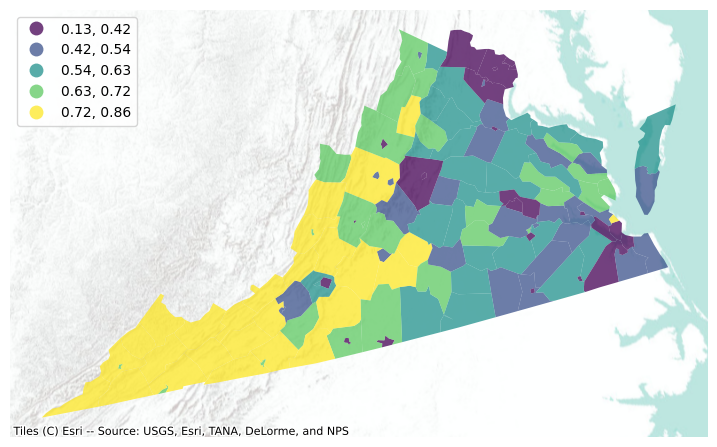

In [53]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    column="per_gop",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax.set_axis_off()

In [40]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

In [55]:
db["per_gop_lag"] = weights.spatial_lag.lag_spatial(
    w, db["per_gop"]
)

In [56]:
db

,US_Counties_20m_GEOID,geometry,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,Pct_Leave_lag,votes_gop_lag,per_gop_lag
0,51075,"POLYGON ((1897374.995 -552190.555, 1900934.960...",Virginia,51075,Goochland County,11521,7875,19616,3646,0.587327,0.401458,0.185869,25566.250,25566.250,0.553157
1,51678,"POLYGON ((1785957.863 -580034.042, 1786657.955...",Virginia,51678,Lexington city,1030,1795,2863,-765,0.359762,0.626965,-0.267202,8415.750,8415.750,0.684432
2,51840,"POLYGON ((1855032.881 -397802.378, 1857382.518...",Virginia,51840,Winchester city,5252,6407,11822,-1155,0.444256,0.541956,-0.097699,25421.375,25421.375,0.619761
3,51081,"POLYGON ((1962880.065 -676661.997, 1967852.948...",Virginia,51081,Greensville County,1936,2334,4296,-398,0.450652,0.543296,-0.092644,4504.875,4504.875,0.452591
4,51011,"POLYGON ((1836635.193 -599673.039, 1842475.534...",Virginia,51011,Appomattox County,7243,2324,9642,4919,0.751193,0.241029,0.510164,9534.875,9534.875,0.608902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,51165,"POLYGON ((1788831.236 -493748.045, 1790725.400...",Virginia,51165,Rockingham County,33033,15035,48581,17998,0.679957,0.309483,0.370474,11349.500,11349.500,0.600772
129,51750,"POLYGON ((1705457.595 -675893.802, 1705589.407...",Virginia,51750,Radford city,3197,3231,6550,-34,0.488092,0.493282,-0.005191,13367.000,13367.000,0.687516
130,51149,"POLYGON ((1977166.275 -600123.657, 1982315.197...",Virginia,51149,Prince George County,10590,6842,17596,3748,0.601841,0.388838,0.213003,15180.750,15180.750,0.461161
131,51690,"POLYGON ((1775578.333 -709526.315, 1776875.450...",Virginia,51690,Martinsville city,2155,3435,5658,-1280,0.380877,0.607105,-0.226228,16857.500,16857.500,0.618373


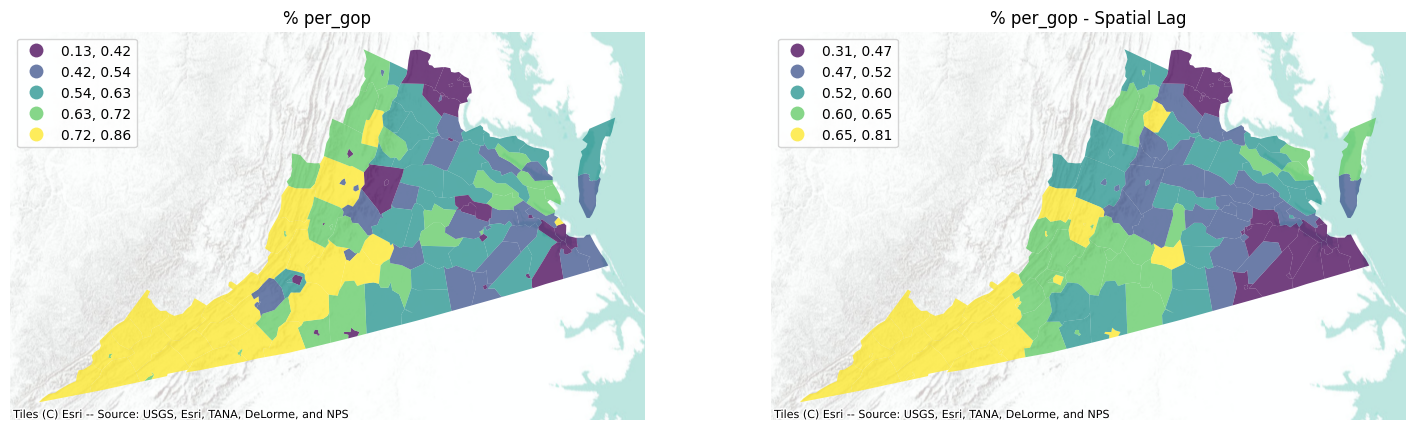

In [58]:
f, axs = plt.subplots(1, 2, figsize=(18, 9))
ax1, ax2 = axs

db.plot(
    column="per_gop",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={'loc': 'upper left'},
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("% per_gop")
contextily.add_basemap(
    ax1,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

db.plot(
    column="per_gop_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={'loc': 'upper left'},
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("% per_gop - Spatial Lag")
contextily.add_basemap(
    ax2,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

plt.show()

In [18]:
db["Leave"] = (db["Pct_Leave"] > 50).astype(int)
db[["Pct_Leave", "Leave"]].tail()

,Pct_Leave,Leave
lad16cd,,
W06000018,57.63,1
W06000019,62.03,1
W06000021,49.56,0
W06000022,55.99,1
W06000023,53.74,1


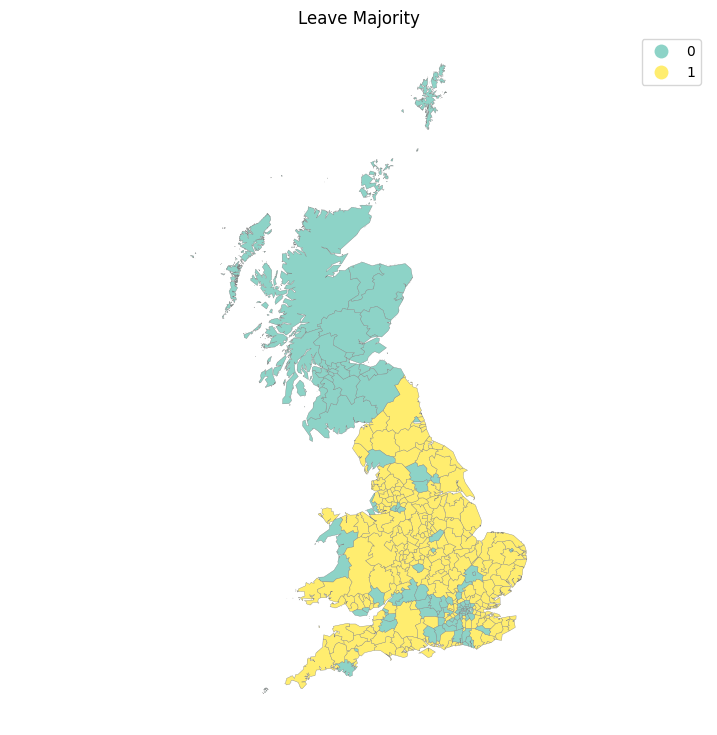

In [19]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    ax=ax,
    column="Leave",
    categorical=True,
    legend=True,
    edgecolor="0.5",
    linewidth=0.25,
    cmap="Set3",
    figsize=(9, 9),
)
ax.set_axis_off()
ax.set_title("Leave Majority")
plt.axis("equal")
plt.show()

In [27]:
w.transform

'R'

In [28]:
w.transform = "O"

In [29]:
w.transform

'O'

In [30]:
seed(1234)
jc = esda.join_counts.Join_Counts(db["Leave"], w)
jc

In [31]:
jc.bb

871.0

In [32]:
jc.ww

302.0

In [33]:
jc.bw

347.0

In [34]:
jc.bb + jc.ww + jc.bw

1520.0

In [35]:
jc.J

1520.0

In [36]:
jc.mean_bb

727.4124124124124

In [37]:
jc.mean_bw

649.3233233233233

In [38]:
jc.p_sim_bb

0.001

In [39]:
jc.p_sim_bw

1.0

In [40]:
db["Pct_Leave_std"] = db["Pct_Leave"] - db["Pct_Leave"].mean()
db["Pct_Leave_lag_std"] = weights.lag_spatial(
    w, db["Pct_Leave_std"]
)

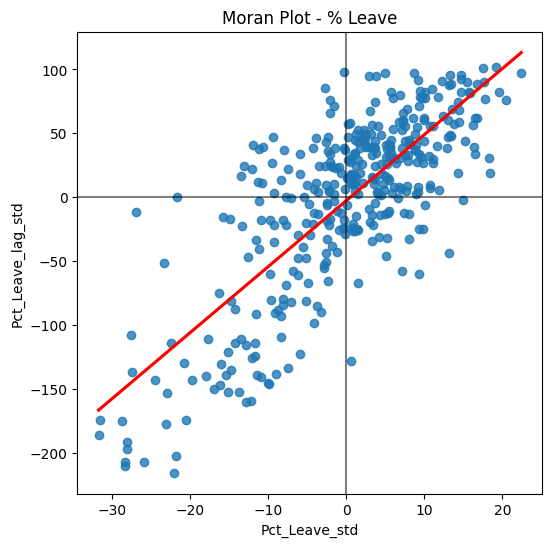

In [41]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x="Pct_Leave_std",
    y="Pct_Leave_lag_std",
    ci=None,
    data=db,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - % Leave")
plt.show()

In [42]:
w.transform = "R"
moran = esda.moran.Moran(db["Pct_Leave"], w)

In [43]:
moran.I

0.6454521298096587

In [44]:
moran.p_sim

0.001

C:\Users\bsb5pw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


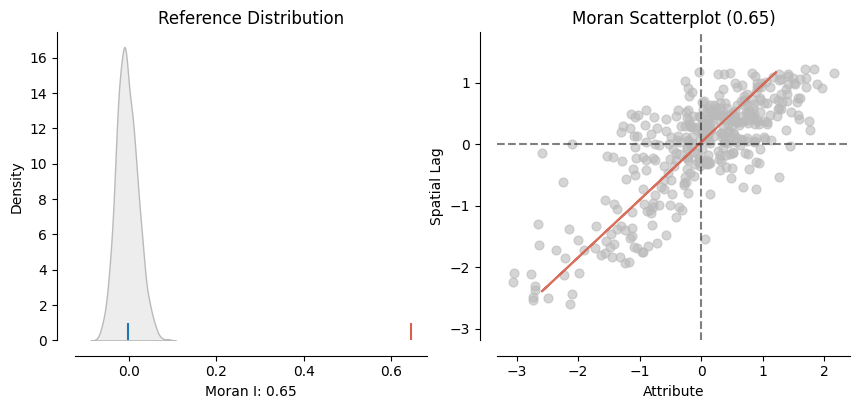

In [45]:
plot_moran(moran);